In [ ]:
import numpy as np
import keras 
import tensorflow as tf

Using TensorFlow backend.


In [ ]:
from keras.datasets.mnist import load_data
(trainX,trainY),(testX,testY) = load_data()
#print(trainX.shape)

11493376/11490434 [==============================] - 1s 0us/step


testing for images 

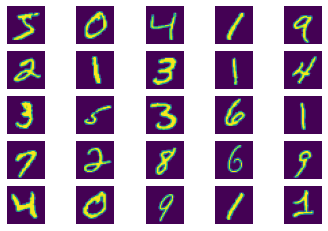

In [ ]:
import matplotlib.pyplot as plt
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.axis('off')
  plt.imshow(trainX[i])
plt.show()

Image in gray scale 

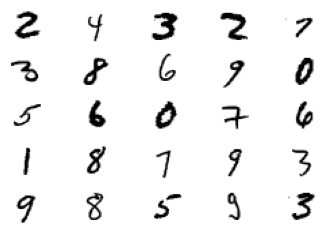

In [ ]:
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.axis('off')
  plt.imshow(trainX[i+25],cmap='gray_r')
plt.show()

Below code is to define and possibly train discriminator model. Note: we need to separately create fake training data as generator has not yet been defined. these fake training data will have labels as 0 while original will have 1. This way we will train our discriminator samples.

In [ ]:
#importing important packages from keras 
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randint
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
import numpy as np

In [ ]:
def define_discriminator(in_shape=(28,28,1)):
  model = Sequential()

  model.add(Conv2D(64,(3,3),strides=(2,2),padding = 'same',input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))

  model.add(Conv2D(64,(3,3),strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))

  model.add(Flatten())
  model.add(Dense(1,activation='sigmoid'))
  model.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.0002,beta_1=0.5),metrics=['accuracy'])
  return model

In [ ]:
def generate_samples_real(dataset,n_samples):
  ix = randint(0,dataset.shape[0],n_samples)
  X = dataset[ix]
  #print("real shape %d", X.shape)
  Y =  ones((n_samples,1))  #since these are real samples
  return X,Y

def loading_real_samples():
  (trainX,_),(_,_) = load_data()
  X = expand_dims(trainX,axis = -1)
  X = X.astype('float32')
  X = X / 255.0  #normalising
  return X

def generate_samples_fake(n_samples):
  X = rand(28*28*n_samples)
  X = X.reshape(n_samples,28,28,1)
  #print("fake shape %d", X.shape)
  Y = zeros((n_samples,1))  #since these are fake samples
  return X,Y

In [ ]:
def train_discriminator(model,dataset,n_iteration = 100,n_batch = 256):
  half_batch = int(n_batch /2)
  for i in range(n_iteration):
    X_real,Y_real= generate_samples_real(dataset,half_batch)
    _,real_acc = model.train_on_batch(X_real,Y_real)
    X_fake,Y_fake = generate_samples_fake(half_batch)
    _,fake_acc = model.train_on_batch(X_fake,Y_fake)
    print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

Running the model after initialisiation 

In [ ]:
model = define_discriminator()
#model.summary()
dataset = loading_real_samples()
train_discriminator(model,dataset)

In [ ]:
from numpy.random import randn
from keras.layers import Conv2DTranspose
from keras.layers import Reshape
from numpy import vstack

The idea of Generator is to get data from random normal distribution, then upscale the dimension using conv2dtranspose function.

In [ ]:
def define_Generator(latent_dims):
  n_nodes = 128*7*7
  model = Sequential()
  model.add(Dense(n_nodes,input_dim=latent_dims))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((7,7,128)))

  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same'))  #will upscale to 14*14 from 7*7
  model.add(LeakyReLU(alpha=0.2))
  
  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same'))  #will upscale to 28*28 from 14*14
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(1,(7,7),activation='sigmoid',padding='same'))
  return model

Generate lateral dimension space from normal dist, hence creating fake samples

In [ ]:
def generate_lateral_points(lateral_dims,n_samples):
  x_input = randn(lateral_dims*n_samples)
  x_input = x_input.reshape(n_samples,lateral_dims)
  return x_input

def generate_samples_fake_G(g_model,latent_dims,n_samples):
  x_input = generate_lateral_points(latent_dims,n_samples)
  X = g_model.predict(x_input)
  Y = zeros((n_samples,1))
  return X,Y

Calling the model to generate samples and checking the generation using pyplot

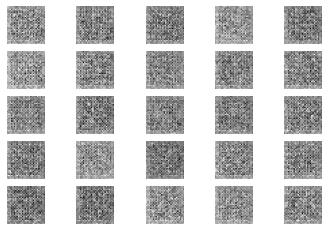

In [ ]:
latent_dims = 100
n_samples = 25
model_G = define_Generator(latent_dims)
X,_ = generate_samples_fake_G(model_G,latent_dims,n_samples)

#view samples
for i  in range(n_samples):
  plt.subplot(5,5,1+i)
  plt.axis('off')
  plt.imshow(X[i,:,:,0],cmap = 'gray_r')    #since X is 4 dims
plt.show()

Defining and setting up the Gan model. Followed by evaluation metric and further saving the plots.

In [ ]:
def define_gan(g_model,d_model):
  d_model.trainable = False   #the trick for training the discriminator not at first but after the model has compiled
  model = Sequential()
  model.add(g_model)
  model.add(d_model)

  model.compile(loss = 'binary_crossentropy',optimizer = Adam(lr = 0.0002, beta_1 = 0.5))
  return model

In [ ]:
def save_plot(examples, epoch, n=10):
  for i in range(n * n):
    plt.subplot(n, n, 1 + i)
    plt.axis('off')
    plt.imshow(examples[i, :, :, 0], cmap='gray_r')
  
  filename = 'generated_plot_e%03d.png' % (epoch+1)
  plt.savefig(filename)
  plt.close()

def define_Summarize_evaluation(epoch,g_model,d_model,dataset,latent_dim,n_samples = 100):
  X_real,Y_real = generate_samples_real(dataset,n_samples)
  _,acc_real = d_model.evaluate(X_real,Y_real,verbose = 0)
  X_fake,Y_fake = generate_samples_fake_G(g_model,latent_dim,n_samples)
  _,acc_fake = d_model.evaluate(X_fake,Y_fake,verbose = 0)
  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
  save_plot(X_fake, epoch)
  filename = 'generator_model_%03d.h5' % (epoch + 1)
  print(filename)
  g_model.save(filename)


Gan training in epoch = 5 and n_batch = 512 this could be changed as per need, however this need GPU for faster calculation.

In [ ]:
def train(g_model,d_model,gan_model,dataset,latent_dim,n_epochs = 5 , n_batch = 512):
  bat_per_epo = int(dataset.shape[0]/n_batch)
  half_batch = int(n_batch/2)
  for i in range(n_epochs):
    for j in range(bat_per_epo):
      X_real,Y_real = generate_samples_real(dataset,half_batch)
      X_fake,Y_fake = generate_samples_fake_G(g_model,latent_dim,half_batch)
      X,Y = vstack((X_real,X_fake)) , vstack((Y_real,Y_fake))
      d_loss,_ = d_model.train_on_batch(X,Y)
      X_gan = generate_lateral_points(latent_dims,n_batch)
      Y_gan = ones((n_batch,1))
      g_loss = gan_model.train_on_batch(X_gan,Y_gan)
      print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
      if (i+1) % 5 == 0:
        define_Summarize_evaluation(i, g_model, d_model, dataset, latent_dim)

In [ ]:
latent_dim = 100
g_model = define_Generator(latent_dim)
d_model = define_discriminator()
gan_model = define_gan(g_model,d_model)
dataset = loading_real_samples()
train(g_model,d_model,gan_model,dataset,latent_dim)


Generating sample images from generator.

In [ ]:
from keras.models import load_model

def saveplots(examples,n):
  for i in range(n*n):
    plt.subplot(n,n,1+i)
    plt.axis('off')
    plt.imshow(examples[i,:,:,0], cmap = 'gray_r')
  plt.show()

model = load_model('generator_model_005.h5')  #file name as printed above.
latent_point = generate_lateral_points(100,25)
X = model.predict(latent_point)

save_plot(X,5)